### Initial env config

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import gc
import cv2 as cv

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy
from tempfile import TemporaryDirectory

pd.set_option('display.max_columns', None)
tqdm.pandas()

random_seed = 10

In [2]:
# Efforts for reproducibility
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [4]:
# Image Paths variables
train_imgPath = '/kaggle/input/ifsp-d3apl-2023-face-recognition/train/train/*/*.jpg'
test_imgPath = '/kaggle/input/ifsp-d3apl-2023-face-recognition/test/test/*.jpg'
train_parent_path = '/kaggle/input/ifsp-d3apl-2023-face-recognition/train/train'
test_parent_path = './kaggle/input/ifsp-d3apl-2023-face-recognition/test/test'

### Check original data

In [5]:
# Total of Train Images grouped by class

d_file_class = {}
class_counter = 0
for sub_dir in os.listdir(train_parent_path):
    target_dir = train_parent_path + '/' + sub_dir
    files = os.listdir(target_dir)    
    count = len(files)
    class_counter += 1
    for f in files:
      d_file_class[target_dir + '/' + f] = sub_dir
    print(f'{str(class_counter):4s} {sub_dir:22s}:{count}')
print(f'\n---\nTotal of class: {len(set(d_file_class.values()))}')

1    Daniel Craig          :148
2    Jennifer Love Hewitt  :87
3    Hugh Laurie           :148
4    Joaquin Phoenix       :88
5    Orlando Bloom         :240
6    Sania Mirza           :108
7    Angelina Jolie        :194
8    Silvio Berlusconi     :101
9    John Travolta         :112
10   Charlize Theron       :175
11   Nicole Richie         :168
12   Kate Moss             :133
13   Zac Efron             :173
14   Matt Damon            :134
15   Julia Stiles          :112
16   Harrison Ford         :130
17   Stephen Colbert       :104
18   Cameron Diaz          :226
19   Eva Mendes            :115
20   Cristiano Ronaldo     :148
21   Jessica Alba          :155
22   Ricky Martin          :123
23   Uma Thurman           :147
24   Shakira               :181
25   Nicole Kidman         :165
26   Adam Sandler          :88
27   Kiefer Sutherland     :115
28   Barack Obama          :249
29   Victoria Beckham      :114
30   Claudia Schiffer      :102
31   David Duchovny        :129
32   Gwynet

### Separate validation set

In [6]:
!pip install split-folders

In [7]:
import splitfolders
# percentage of training set to use as validation
valid_size = 0.2

splitfolders.ratio(train_parent_path, output="output", seed=random_seed, ratio=(.8, valid_size))

Copying files: 12180 files [00:56, 217.09 files/s]


In [8]:
!tree /kaggle/working/output --dirsfirst --filelimit 50 

/kaggle/working/output
├── train  [83 entries exceeds filelimit, not opening dir]
└── val  [83 entries exceeds filelimit, not opening dir]

2 directories, 0 files


### Duplicate the training data folder for oversampling

In [9]:
import shutil
# Set the paths for the input and output directories
input_dir = '/kaggle/working/output/train'
oversampled_dir = '/kaggle/working/oversampled/train'

# Duplicate the entire folder
shutil.copytree(input_dir, oversampled_dir)

'/kaggle/working/oversampled/train'

### Oversampling training data

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the desired number of samples per class
desired_samples = 5000

# Create an instance of the ImageDataGenerator
data_generator = ImageDataGenerator(   
    rotation_range=20,  # Randomly rotate images within the range of 20 degrees    
    shear_range=0.2,  # Apply random shear transformations
    zoom_range=0.2,  # Apply random zoom transformations
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill any newly created pixels after rotation or shifting
)

# Iterate through the folders representing each class
for class_folder in os.listdir(oversampled_dir):
    class_folder_path = os.path.join(oversampled_dir, class_folder)
    
    if os.path.isdir(class_folder_path):
        # Get the list of images in the current class folder
        images = os.listdir(class_folder_path)        
        # Calculate the number of existing samples in the class
        existing_samples = len(images)
        
        if existing_samples < desired_samples:
            # Calculate the number of additional samples needed
            additional_samples = desired_samples - existing_samples
            # Create a data generator for the current class folder
            generator = data_generator.flow_from_directory(
                directory=oversampled_dir,
                target_size=(100, 100),  # Adjust the target size as per your requirements
                batch_size=1,
                class_mode='categorical',
                classes=[class_folder],
                shuffle=True,
                save_to_dir=class_folder_path, 
                save_prefix='aug-',
                save_format='jpg'
            )
            
            # Generate additional samples using the data generator
            for i in range(additional_samples):
                batch = next(generator)
                imagem = batch[0]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Found 83 images belonging to 1 classes.
Found 138 images belonging to 1 classes.
Found 192 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 84 images belonging to 1 classes.
Found 223 images belonging to 1 classes.
Found 86 images belonging to 1 classes.
Found 267 images belonging to 1 classes.
Found 152 images belonging to 1 classes.
Found 155 images belonging to 1 classes.
Found 148 images belonging to 1 classes.
Found 224 images belonging to 1 classes.
Found 89 images belonging to 1 classes.
Found 118 images belonging to 1 classes.
Found 116 images belonging to 1 classes.
Found 86 images belonging to 1 classes.
Found 76 images belonging to 1 classes.
Found 77 images belonging to 1 classes.
Found 105 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
Found 73 images belonging to 1 classes.
Found 90 images belonging to 1 classes.
Found 104 images belonging to 1 classes.
Found 106 images belonging to 1 classes.
Found 64 images belonging 

In [12]:
# Check augmented data

d_file_class = {}
class_counter = 0
for sub_dir in os.listdir(oversampled_dir):
    target_dir = oversampled_dir + '/' + sub_dir
    files = os.listdir(target_dir)    
    count = len(files)
    class_counter += 1
    for f in files:
      d_file_class[target_dir + '/' + f] = sub_dir
    print(f'{str(class_counter):4s} {sub_dir:22s}:{count}')
print(f'\n---\nTotal of class: {len(set(d_file_class.values()))}')

1    Stephen Colbert       :5000
2    Zac Efron             :5000
3    Orlando Bloom         :5000
4    Meryl Streep          :5000
5    Beyonce Knowles       :5000
6    Avril Lavigne         :5000
7    Will Smith            :5000
8    Lindsay Lohan         :5000
9    Meg Ryan              :5000
10   Angelina Jolie        :5000
11   Sharon Stone          :5000
12   Jessica Simpson       :5000
13   Julia Stiles          :5000
14   Daniel Craig          :5000
15   Steve Carell          :5000
16   Sania Mirza           :5000
17   Faith Hill            :5000
18   Ben Affleck           :5000
19   Drew Barrymore        :5000
20   Joaquin Phoenix       :5000
21   Colin Powell          :5000
22   Renee Zellweger       :5000
23   Harrison Ford         :4999
24   Kate Moss             :5000
25   Jack Nicholson        :5000
26   Morgan Freeman        :5000
27   Ehud Olmert           :5000
28   Christina Ricci       :5000
29   Ashton Kutcher        :5000
30   Victoria Beckham      :5000
31   Julia

In [13]:
# Generate pandas dataframe from traning dataset
df_train_imgs = pd.DataFrame(list(d_file_class.items()), columns=['img_path', 'class'])
df_train_imgs.sample(5)

,img_path,class
567,/kaggle/working/oversampled/train/Stephen Colb...,Stephen Colbert
100207,/kaggle/working/oversampled/train/Colin Powell...,Colin Powell
272177,/kaggle/working/oversampled/train/Cate Blanche...,Cate Blanchett
324241,/kaggle/working/oversampled/train/Miley Cyrus/...,Miley Cyrus
281200,/kaggle/working/oversampled/train/Adam Sandler...,Adam Sandler


In [14]:
def show_image(Path, Picture_Name):
    img = cv.imread(Path)[:,:,::-1]
    plt.imshow(img)
    plt.title(Picture_Name)
    plt.axis('off')
    plt.show()

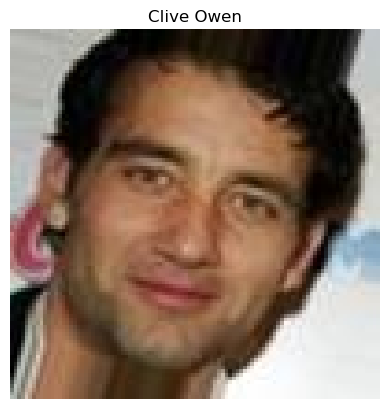

In [15]:
random_train_img = df_train_imgs.sample(1)
_path = random_train_img['img_path'].squeeze()
_title = random_train_img['class'].squeeze()
show_image(_path, _title)

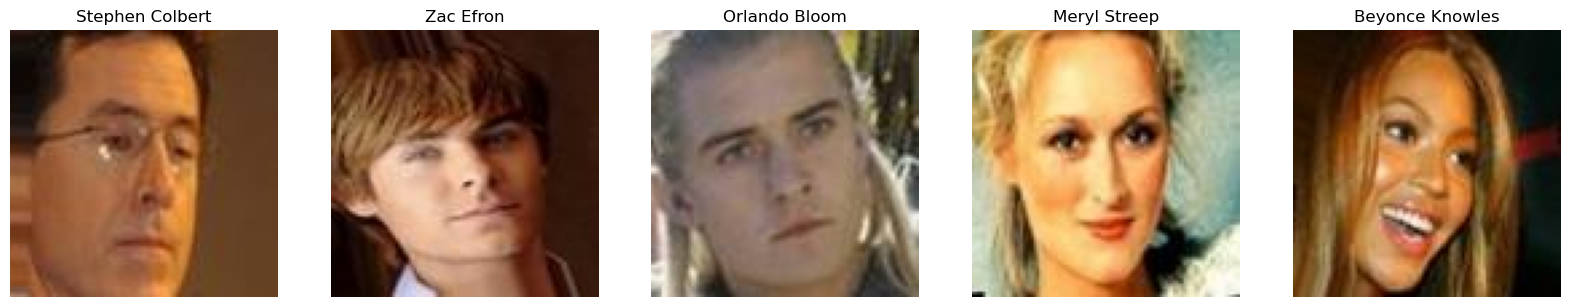

In [16]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    img = cv.imread(df_train_imgs['img_path'].iloc[i*5000])[:,:,::-1]
    ax[i].imshow(img)
    ax[i].set_title(df_train_imgs['class'].iloc[i*5000])
    ax[i].axis('off')

### Data loader and preprocessing

In [28]:
BATCH_SIZE = 415
NUM_WORKERS = 2
LR = 0.001
MOMENTUM = 0.9
EPOCHS = 1000
EARLY_EPOCHS = 70
DROPOUT = .2

In [29]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),        
        transforms.RandomHorizontalFlip(p=0.6),
        transforms.RandomRotation(degrees=(0, 50)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=100),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [30]:
data_dir = {'train': '/kaggle/working/oversampled', 'val':'/kaggle/working/output'}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir[x], x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### Load pretrained model

In [31]:
#model_ft = models.resnet18(pretrained=True)
model_conv = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# we need to freeze all the network except the final layer
for param in model_conv.parameters():
    param.requires_grad = False

### Add additional layer

In [32]:
fc_inputs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(fc_inputs, len(class_names))
model_conv.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(DROPOUT),
    nn.Linear(256, len(class_names)), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

### Setup optimizer, loss function

In [33]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

# all parameters are being optimized
# optimizer_ft = optim.SGD(model_conv.parameters(), lr=LR, momentum=MOMENTUM)
optimizer_ft = optim.Adam(model_conv.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [34]:
# Checking if GPU is avalilable
train_on_gpu = torch.cuda.is_available()
device = 'cpu'
if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')
    device = 'cuda:0'

model_conv = model_conv.to(device)

CUDA is available! Training on GPU ...


### Train model

In [35]:
cudnn.benchmark = True
plt.ion()

In [52]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, early_stopping_epochs=10):
    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        epochs_without_improv = 0
        best_epoch = None
        history = []

        for epoch in tqdm(range(num_epochs)):
            #print(f'Epoch {epoch}/{num_epochs - 1}')
            #print('-' * 10)
            ###################
            # early stopping? #
            ###################
            if epochs_without_improv >= early_stopping_epochs:
                break
        
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # print(f'{phase:10s}-> Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    epochs_without_improv = 0
                    torch.save(model.state_dict(), best_model_params_path)
                elif phase == 'val' and epoch_acc <= best_acc:
                    epochs_without_improv += 1

            # print()

        time_elapsed = time.time() - since
        # Print logs
        if epochs_without_improv >= early_stopping_epochs:
            print('Training interrupted by early stopping!')
        else:
            print('Training finished by epochs!')
        print(f'Total epochs run: {epoch + 1}')
        print(f'Best model found at epoch: {best_epoch + 1}')
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [53]:
model_ft = train_model(model_conv, 
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler, 
                       num_epochs=EPOCHS, 
                       early_stopping_epochs=EARLY_EPOCHS)

  0%|          | 0/1000 [02:11<?, ?it/s]


KeyboardInterrupt: 

In [36]:
train_data_size = len(image_datasets['train'])
valid_data_size = len(image_datasets['val'])

In [37]:
train_data_size, valid_data_size

(414999, 2467)

In [ ]:
history = []
best_valid_loss = np.Inf
best_epoch = None
epochs_without_improv = 0

for epoch in tqdm(range(EPOCHS)):
    ###################
    # early stopping? #
    ###################
    if epochs_without_improv >= EARLY_EPOCHS:
        break
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, EPOCHS))
    # Set to training mode
    model_conv.train()
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Clean existing gradients
        optimizer_ft.zero_grad()
        # Forward pass - compute outputs on input data using the model
        outputs = model_conv(inputs)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backpropagate the gradients
        loss.backward()
        # Update the parameters
        optimizer_ft.step()
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
        if i > 0 and i%BATCH_SIZE == 0:
            print(".", end="")
        #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model_conv.eval()        
        # Validation loop        
        for j, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass - compute outputs on input data using the model
            outputs = model_conv(inputs)
            # Compute loss
            loss = criterion(outputs, labels)
            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)
            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)
            #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    #####################
    # Update best model #
    #####################
    if valid_loss < best_valid_loss:
        torch.save(model_conv.state_dict(), 'best_model') # save best model
        best_epoch = epoch
        best_valid_loss = valid_loss        
        epochs_without_improv = 0
    else:
        epochs_without_improv += 1
    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size 
    avg_train_acc = train_acc/float(train_data_size)
    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size 
    avg_valid_acc = valid_acc/float(valid_data_size)
    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
    epoch_end = time.time()
    print("\nTraining: Loss: {:.3f}, Accuracy: {:.3f}%, nttValidation : Loss : {:.3f}, Accuracy: {:.3f}%, Time: {:.1f}s".format(avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start),end='\n\n')

# Print logs
if epochs_without_improv >= early_stopping_epochs:
    print('Training interrupted by early stopping!')
else:
    print('Training finished by epochs!')
print(f'Total epochs run: {epoch + 1}')
print(f'Best model found at epoch {best_epoch + 1} with valid loss {best_valid_loss}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1/1000
.

In [113]:
hist_df =  pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
hist_df.head()

,train_loss,valid_loss,train_acc,valid_acc
0,3.331746,3.387123,0.170905,0.150385
1,3.329561,3.402952,0.175023,0.153628
2,3.316067,3.390212,0.177700,0.153628
3,3.307404,3.378875,0.173994,0.155249
4,3.316404,3.391584,0.172655,0.151196


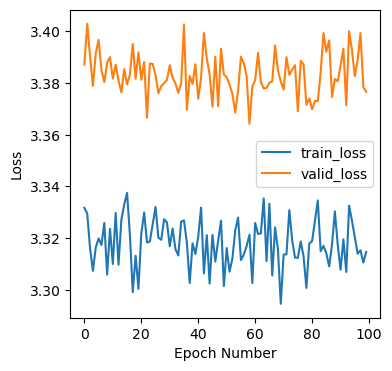

In [116]:
hist_df[['train_loss', 'valid_loss']].plot(figsize=(4, 4))
plt.xlabel('Epoch Number')
plt.ylabel('Loss');